In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize 

import warnings
warnings.filterwarnings("ignore")

# Import own libraries 
import os, sys
script_path = os.path.realpath(os.path.dirname("10_on_trajectories"))
os.chdir(script_path)
sys.path.append("..")

from myLibraries.queries import * 
from myLibraries.events import *
from myLibraries.theoretical_functions import *

In [2]:
HOLE_SIZE = 28

EVENTS = get_collabs_event()
ALL_EVENTS = get_allEvents(EVENTS)

YEARS = get_str_years_event()

# get rid of misleading years
YEARS_TO_CONSIDER = YEARS[11: -8]
EVENTS_TO_CONSIDER = YEARS[11: -8]

WINDOW = 5
SECTION = 8

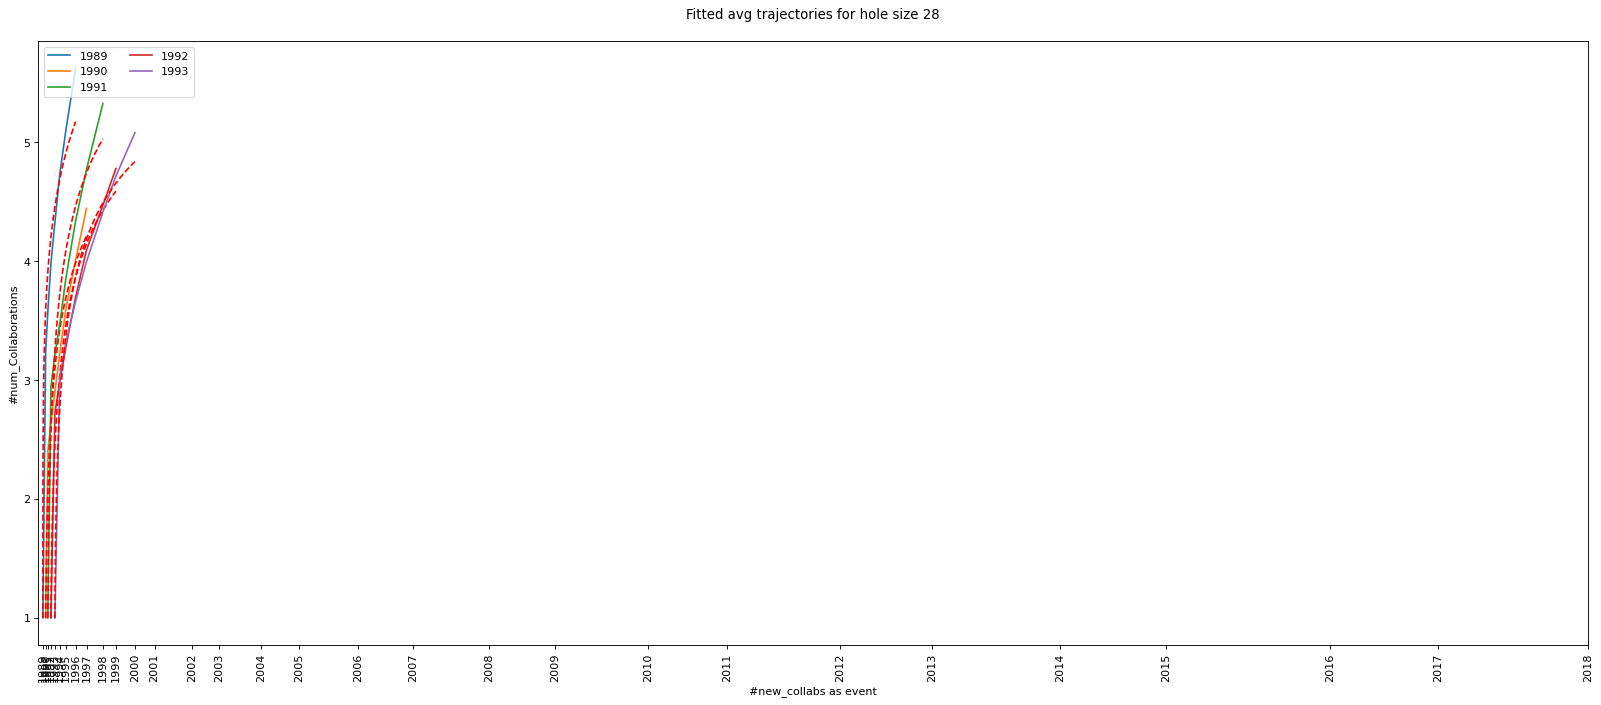

In [66]:
curr_win = 0
while len(YEARS)-SECTION >= WINDOW+curr_win-1:
    ## Plot fitted average trajectories
    plt.figure(figsize=(25, 10), dpi=80)
    plt.title("Fitted avg trajectories for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
    plt.xlabel("#new_collabs as event")
    plt.ylabel("#num_Collaborations")
    plt.xticks(rotation='vertical')

    alphas = []
    betas = []
    for start_y in YEARS[curr_win:WINDOW+curr_win]:
        
        
        x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y, section=SECTION) # retrieve average trajecory for the given start_y (and hole size)     

        
        fit_y, alpha, beta = fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 
        
        xdata = [a for a in range(x[0], x[-1])]
        fit_y = theoretical_func(xdata, alpha, beta, x[0])

        # save fitted parameters alpha, beta
        alphas.append(alpha)
        betas.append(beta)
        
        plt.plot(x,y, label=str(start_y))
        plt.plot(xdata, fit_y, 'r--')

    plt.xticks(rotation='vertical')    
    plt.legend(loc='upper left', ncol=2)
    plt.xticks(EVENTS, YEARS)
    plt.show()
    curr_win += 1
    
    break

In [63]:
##### ERRORS FUNCTIONS FOR AVERAGE TRAJECTORIES #####

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with real data 
def err_f_A(params, xdata, hole_size, years_to_consider=YEARS):
    opt_alpha, opt_beta = params
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)
        x,y = get_avg_trajectories(xdata, hole_size, start_y, section=SECTION)
        
        for curr_y in YEARS[i:][:i+SECTION]:
            e = YEARS.index(curr_y)
            try:
                err += pow(abs(theoretical_func(xdata[e], opt_alpha, opt_beta, xdata[i]) - y[YEARS[i:][:-1].index(curr_y)]), 2)
            except:
                0==0
    sys.stdout.write('\r'+ "optimizing A function with -> params: " + str(params) +", error: "+ str(err))
    return err

SUBSET_SIZE = 200 # the next error function works on all events, choose the number of event to be considered 

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with fitted data f_i 
        ## we consider a subset of events for computational costs
def err_f_C(params, xdata, hole_size, years_to_consider=YEARS):
    opt_alpha, opt_beta = params
    
    size = SUBSET_SIZE # subset of events to consider 
    
    all_events = [e for e in range(xdata[-1])]
    next_events = all_events
    n = (len(next_events))//size
        
    events_subset = [next_events[e] for e in range(len(next_events)) if e%n==0][:size]
        
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)    
        curr_x = xdata[i]  
        
        x,y = get_avg_trajectories(xdata, hole_size, start_y, section=SECTION)
        fit_y, alpha, beta = fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 
        
        
        for e in events_subset:
            if(e>curr_x):
                try:
                    err += pow(abs(theoretical_func(e, opt_alpha, opt_beta, xdata[i]) - theoretical_func(e, alpha, beta, xdata[i])), 2)
                except:
                    0==0
    sys.stdout.write('\r'+ "optimizing C function with " + str(size) + " events -> params: " + str(params) +", error: "+ str(err))
    return err

In [65]:
# minimize errors
curr_win = 0
while len(YEARS)-SECTION >= WINDOW+curr_win-1:
    
    ## optimize alpha* and beta* for each error function defined above 
    alphas_opt,betas_opt, errs = [],[],[]

    start_params = [1, 1]
    bnds = ((0, None), (0, None))

    # retrieve alpha* and beta* minimizing the associated function and
        # compute the error made by the optimized parameters 

    result_A = minimize(err_f_A, start_params, args=(EVENTS, HOLE_SIZE,  YEARS[curr_win:WINDOW+curr_win]), bounds=bnds)
    fitted_params_A = result_A.x
    alphas_opt.append(fitted_params_A[0])
    betas_opt.append(fitted_params_A[1])
    errs.append(err_f_A(fitted_params_A, EVENTS, HOLE_SIZE,  YEARS[curr_win:WINDOW+curr_win]))
    print()


    result_C = minimize(err_f_C, [1, 1], args=(EVENTS, HOLE_SIZE,  YEARS[curr_win:WINDOW+curr_win]), bounds=bnds)
    fitted_params_C = result_C.x
    alphas_opt.append(fitted_params_C[0])
    betas_opt.append(fitted_params_C[1])
    errs.append(err_f_C(fitted_params_C, EVENTS, HOLE_SIZE,  YEARS[curr_win:WINDOW+curr_win]))
    print()
        
    print(YEARS[curr_win:WINDOW+curr_win], "->", alphas_opt, betas_opt, errs )
    
    curr_win += 1
    

optimizing A function with -> params: [3.36810842e+04 1.21890661e-01], error: 15.123330117978723
optimizing C function with 200 events -> params: [206.35680128   0.26326257], error: 277.04195587445713
['1989', '1990', '1991', '1992', '1993'] -> [33681.08423674806, 206.35680128090115] [0.12189066133857351, 0.2632625729887676] [15.12333011797872, 277.0419558744571]
optimizing A function with -> params: [67.80241096  0.29963415], error: 8.6647039677621743
optimizing C function with 200 events -> params: [103.86712636   0.29540836], error: 138.02943805506246
['1990', '1991', '1992', '1993', '1994'] -> [67.80241095884962, 103.8671263586843] [0.29963414842624564, 0.2954083625604028] [8.664703967762174, 138.02943805506246]
optimizing A function with -> params: [107.34930715   0.29341858], error: 10.155700842710594
optimizing C function with 200 events -> params: [3.06367196e+02 2.58944421e-01], error: 247.46248331282024
['1991', '1992', '1993', '1994', '1995'] -> [107.34930714793492, 306.3671

In [3]:
# store all variables for each window and type of error (A,C)
all_alphas = [] # all_alphas[i][1] is associated to error A for window i, all_alphas[i][2] is associated to error C for window i
all_betas = [] # same for betas
all_errs = [] #same for errors

#['1989', '1990', '1991', '1992', '1993'] 
all_alphas.append([33681.08423674806, 206.35680128090115])
all_betas.append([0.12189066133857351, 0.2632625729887676])
all_errs.append([15.12333011797872, 277.0419558744571])

#['1990', '1991', '1992', '1993', '1994'] 
all_alphas.append([67.80241095884962, 103.8671263586843])
all_betas.append([0.29963414842624564, 0.2954083625604028]) 
all_errs.append([8.664703967762174, 138.02943805506246])
  
#['1991', '1992', '1993', '1994', '1995']
all_alphas.append([107.34930714793492, 306.3671963064066])
all_betas.append([0.29341858320968145, 0.2589444206328555]) 
all_errs.append([10.155700842710594, 247.46248331282024])

#['1992', '1993', '1994', '1995', '1996']
all_alphas.append([221.69417204475818, 5474.076512248403])
all_betas.append( [0.2669043316739212, 0.18644001651867848] )
all_errs.append([13.022711778187983, 392.6494289462323])

#['1993', '1994', '1995', '1996', '1997']
all_alphas.append([809.6279499977611, 65573.47884440253])
all_betas.append([0.2354851129821727, 0.15700236964212919])
all_errs.append( [33.18549690472552, 1474.4784262244768])

#['1994', '1995', '1996', '1997', '1998']
all_alphas.append([1498.0392430021302, 33978.35835928043])
all_betas.append( [0.22638445319808706, 0.17094181251034268]) 
all_errs.append([28.98340167915768, 1178.333707100658])

#['1995', '1996', '1997', '1998', '1999']
all_alphas.append([2174.497474729857, 33093.018982156544])
all_betas.append( [0.2299616723827333, 0.17936153273039643]) 
all_errs.append([28.734820600591746, 1119.2991968244753])

#['1996', '1997', '1998', '1999', '2000']
all_alphas.append([1805.410236091794, 14148.373477261739])
all_betas.append( [0.24560707772696505, 0.19982249447493966]) 
all_errs.append([24.410568571462534, 947.1489572971045])

#['1997', '1998', '1999', '2000', '2001']
all_alphas.append([2289.519933725278, 73280.28900888751])
all_betas.append([0.26094530232143953, 0.1861388064845196])
all_errs.append( [100.20200068502241, 4839.0609535008625])

#['1998', '1999', '2000', '2001', '2002']
all_alphas.append([2101.651619881387, 24938.15617637248])
all_betas.append([0.2673285313270025, 0.2055974187479982])
all_errs.append( [93.0897826454725, 4742.71837369707])

#['1999', '2000', '2001', '2002', '2003']
all_alphas.append([3438.1810216822696, 35728.54965015428])
all_betas.append( [0.2655325663357454, 0.20955524629298847]) 
all_errs.append([101.27242277441901, 4728.447049404996])

#['2000', '2001', '2002', '2003', '2004']
all_alphas.append([2848.9340812698906, 6951.571701266645])
all_betas.append([0.27776161856429915, 0.2509821241089188])
all_errs.append( [83.30328535096908, 3907.8095005737564])

#['2001', '2002', '2003', '2004', '2005']
all_alphas.append([2130.2500697566174, 2636.671702317526])
all_betas.append([0.29994292110627807, 0.29099316611914167])
all_errs.append([59.53773297674191, 2828.2277024026557])

#['2002', '2003', '2004', '2005', '2006']
all_alphas.append([3639.3851035022353, 13534.15294028037])
all_betas.append([0.27563021604757837, 0.23794429866917963])
all_errs.append([49.90044406769523, 2103.8809770686307])

#['2003', '2004', '2005', '2006', '2007']
all_alphas.append([2610.440690293579, 3020.1982278333858])
all_betas.append( [0.2968325349200288, 0.291039962061732])
all_errs.append([20.199641626261393, 763.3122518777229])

#['2004', '2005', '2006', '2007', '2008']
all_alphas.append([2651.0579436175535, 3485.016431971787])
all_betas.append([0.2923672705909695, 0.28220980107647375])
all_errs.append( [19.52791090432297, 717.534114490952])

#['2005', '2006', '2007', '2008', '2009']
all_alphas.append([3242.302450892483, 4117.465036734518])
all_betas.append([0.29331135370750683, 0.2845718151866555])
all_errs.append( [35.92023860041313, 867.7378086573119])

#['2006', '2007', '2008', '2009', '2010']
all_alphas.append([6774.668287146351, 12400.014486564423])
all_betas.append( [0.26698632490042934, 0.24916589686810017] )
all_errs.append([35.53834470612961, 790.3024564192042])

#['2007', '2008', '2009', '2010', '2011']
all_alphas.append([17146.26596112293, 23850.29440369845])
all_betas.append([0.24672000533476227, 0.238693182144675])
all_errs.append( [48.27843247978381, 1005.9970113813154])


In [13]:
curr_win = 0
windows_years = []
while len(YEARS)-SECTION >= WINDOW+curr_win-1:
    windows_years.append(YEARS[curr_win:WINDOW+curr_win])
    curr_win += 1
windows_years

[['1989', '1990', '1991', '1992', '1993'],
 ['1990', '1991', '1992', '1993', '1994'],
 ['1991', '1992', '1993', '1994', '1995'],
 ['1992', '1993', '1994', '1995', '1996'],
 ['1993', '1994', '1995', '1996', '1997'],
 ['1994', '1995', '1996', '1997', '1998'],
 ['1995', '1996', '1997', '1998', '1999'],
 ['1996', '1997', '1998', '1999', '2000'],
 ['1997', '1998', '1999', '2000', '2001'],
 ['1998', '1999', '2000', '2001', '2002'],
 ['1999', '2000', '2001', '2002', '2003'],
 ['2000', '2001', '2002', '2003', '2004'],
 ['2001', '2002', '2003', '2004', '2005'],
 ['2002', '2003', '2004', '2005', '2006'],
 ['2003', '2004', '2005', '2006', '2007'],
 ['2004', '2005', '2006', '2007', '2008'],
 ['2005', '2006', '2007', '2008', '2009'],
 ['2006', '2007', '2008', '2009', '2010'],
 ['2007', '2008', '2009', '2010', '2011']]

In [25]:
curr_win = 0

alphas_A = []
alphas_C = []

betas_A = []
betas_C = []

errs_A = []
errs_C = []

while len(YEARS)-SECTION >= WINDOW+curr_win-1:
    
    alpha_A = all_alphas[curr_win][0]
    beta_A = all_betas[curr_win][0]
    err_A = all_errs[curr_win][0]
    
    # creates arrays to plot each parameter
    alphas_A.append(alpha_A)
    betas_A.append(beta_A)
    errs_A.append(err_A)

    alpha_C = all_alphas[curr_win][1]
    beta_C = all_betas[curr_win][1]
    err_C = all_errs[curr_win][1]
    
    # create arrays to plot each parameter 
    alphas_C.append(alpha_C)
    betas_C.append(beta_C)
    errs_C.append(err_C)
    
    print()
    print("="*15,windows_years[curr_win],"="*15 )
    print(pd.DataFrame([[[err_A, err_C][i], [alpha_A, alpha_C][i], [beta_A, beta_C][i]] for i in range(2)], ["A", "C"], ["ERROR", "alpha", "beta",]))
    
    curr_win += 1


=============== ['1989', '1990', '1991', '1992', '1993'] ===============
        ERROR         alpha      beta
A   15.123330  33681.084237  0.121891
C  277.041956    206.356801  0.263263

=============== ['1990', '1991', '1992', '1993', '1994'] ===============
        ERROR       alpha      beta
A    8.664704   67.802411  0.299634
C  138.029438  103.867126  0.295408

=============== ['1991', '1992', '1993', '1994', '1995'] ===============
        ERROR       alpha      beta
A   10.155701  107.349307  0.293419
C  247.462483  306.367196  0.258944

=============== ['1992', '1993', '1994', '1995', '1996'] ===============
        ERROR        alpha      beta
A   13.022712   221.694172  0.266904
C  392.649429  5474.076512  0.186440

=============== ['1993', '1994', '1995', '1996', '1997'] ===============
         ERROR         alpha      beta
A    33.185497    809.627950  0.235485
C  1474.478426  65573.478844  0.157002

=============== ['1994', '1995', '1996', '1997', '1998'] ==============

## **ERROR A** -> alphas betas and errors for each window

In [52]:
print(pd.DataFrame([[windows_years[i], alphas_A[i], betas_A[i], errs_A[i]] for i in range(len(alphas_A))], columns=["window", "alpha", "beta", "error A"]))

                            window         alpha      beta     error A
0   [1989, 1990, 1991, 1992, 1993]  33681.084237  0.121891   15.123330
1   [1990, 1991, 1992, 1993, 1994]     67.802411  0.299634    8.664704
2   [1991, 1992, 1993, 1994, 1995]    107.349307  0.293419   10.155701
3   [1992, 1993, 1994, 1995, 1996]    221.694172  0.266904   13.022712
4   [1993, 1994, 1995, 1996, 1997]    809.627950  0.235485   33.185497
5   [1994, 1995, 1996, 1997, 1998]   1498.039243  0.226384   28.983402
6   [1995, 1996, 1997, 1998, 1999]   2174.497475  0.229962   28.734821
7   [1996, 1997, 1998, 1999, 2000]   1805.410236  0.245607   24.410569
8   [1997, 1998, 1999, 2000, 2001]   2289.519934  0.260945  100.202001
9   [1998, 1999, 2000, 2001, 2002]   2101.651620  0.267329   93.089783
10  [1999, 2000, 2001, 2002, 2003]   3438.181022  0.265533  101.272423
11  [2000, 2001, 2002, 2003, 2004]   2848.934081  0.277762   83.303285
12  [2001, 2002, 2003, 2004, 2005]   2130.250070  0.299943   59.537733
13  [2

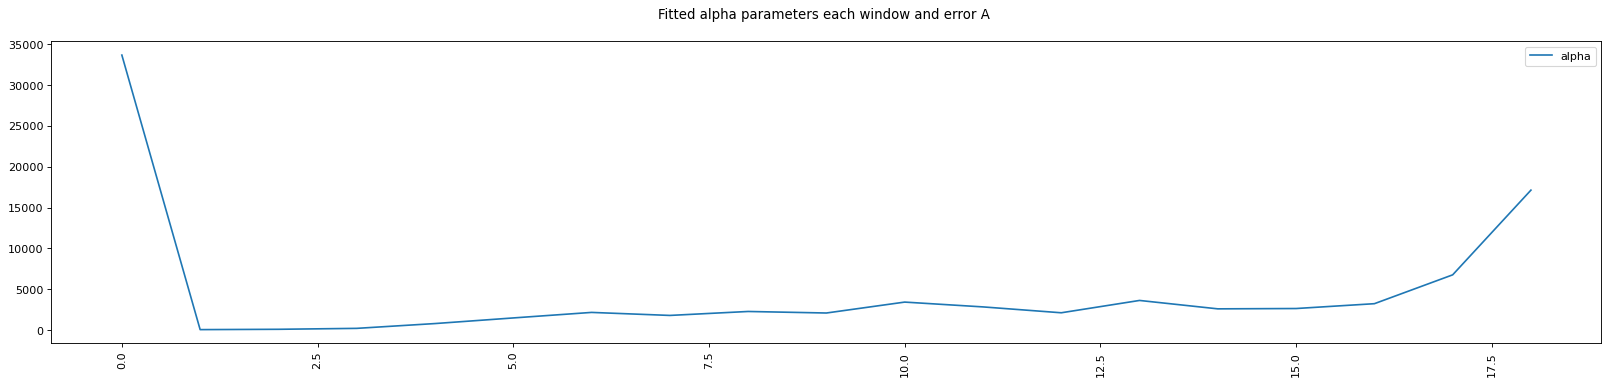

In [40]:
## Plotting fitted parameters alpha for each window
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted alpha parameters each window and error A \n", fontdict = {'fontsize' : 12})

plt.plot(alphas_A, label="alpha")

plt.xticks(rotation='vertical')
plt.legend()
plt.show()

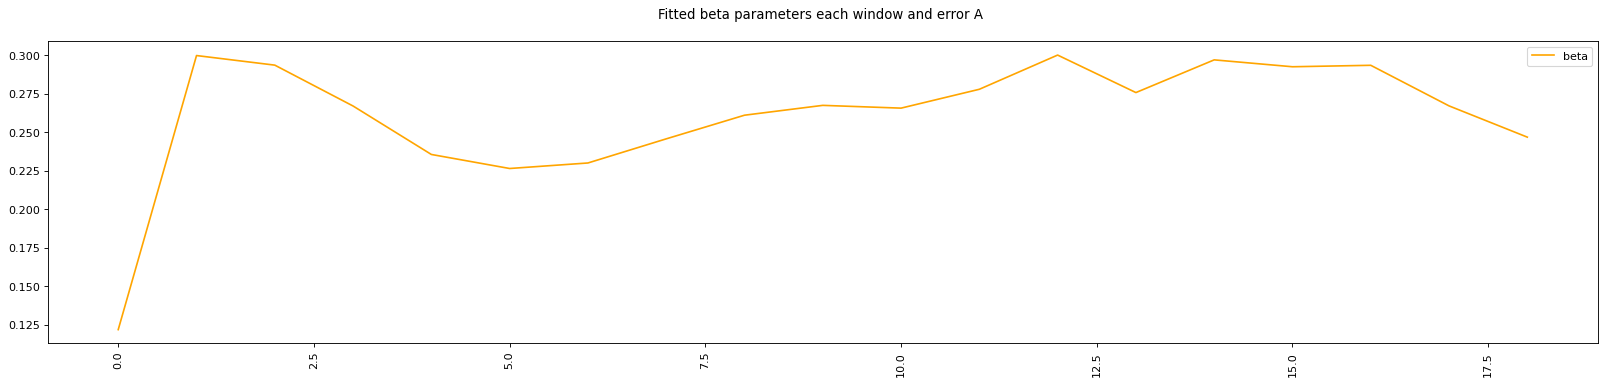

In [46]:
## Plotting fitted parameters beta for each window
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted beta parameters each window and error A \n", fontdict = {'fontsize' : 12})

plt.plot(betas_A, label="beta", color="orange")

plt.xticks(rotation='vertical')
plt.legend()
plt.show()

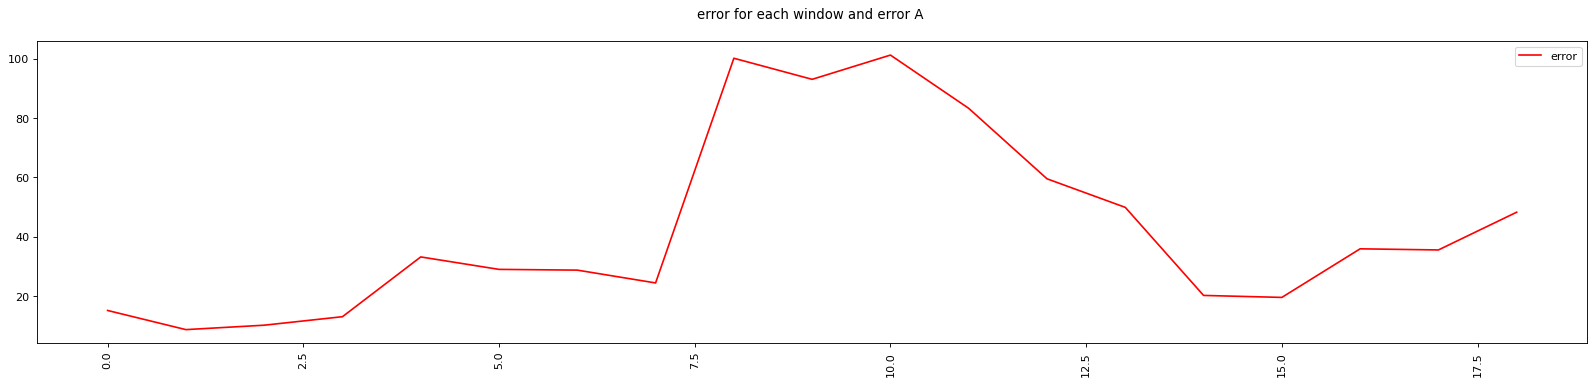

In [47]:
## Plotting error for each window
plt.figure(figsize=(25, 5), dpi=80)
plt.title("error for each window and error A \n", fontdict = {'fontsize' : 12})

plt.plot(errs_A, label="error", color="red")

plt.xticks(rotation='vertical')
plt.legend()
plt.show()

## **ERROR C** -> alphas betas and errors for each window

In [53]:
print(pd.DataFrame([[windows_years[i], alphas_C[i], betas_C[i], errs_C[i]] for i in range(len(alphas_A))], columns=["window", "alpha", "beta", "error B"]))

                            window         alpha      beta      error B
0   [1989, 1990, 1991, 1992, 1993]    206.356801  0.263263   277.041956
1   [1990, 1991, 1992, 1993, 1994]    103.867126  0.295408   138.029438
2   [1991, 1992, 1993, 1994, 1995]    306.367196  0.258944   247.462483
3   [1992, 1993, 1994, 1995, 1996]   5474.076512  0.186440   392.649429
4   [1993, 1994, 1995, 1996, 1997]  65573.478844  0.157002  1474.478426
5   [1994, 1995, 1996, 1997, 1998]  33978.358359  0.170942  1178.333707
6   [1995, 1996, 1997, 1998, 1999]  33093.018982  0.179362  1119.299197
7   [1996, 1997, 1998, 1999, 2000]  14148.373477  0.199822   947.148957
8   [1997, 1998, 1999, 2000, 2001]  73280.289009  0.186139  4839.060954
9   [1998, 1999, 2000, 2001, 2002]  24938.156176  0.205597  4742.718374
10  [1999, 2000, 2001, 2002, 2003]  35728.549650  0.209555  4728.447049
11  [2000, 2001, 2002, 2003, 2004]   6951.571701  0.250982  3907.809501
12  [2001, 2002, 2003, 2004, 2005]   2636.671702  0.290993  2828

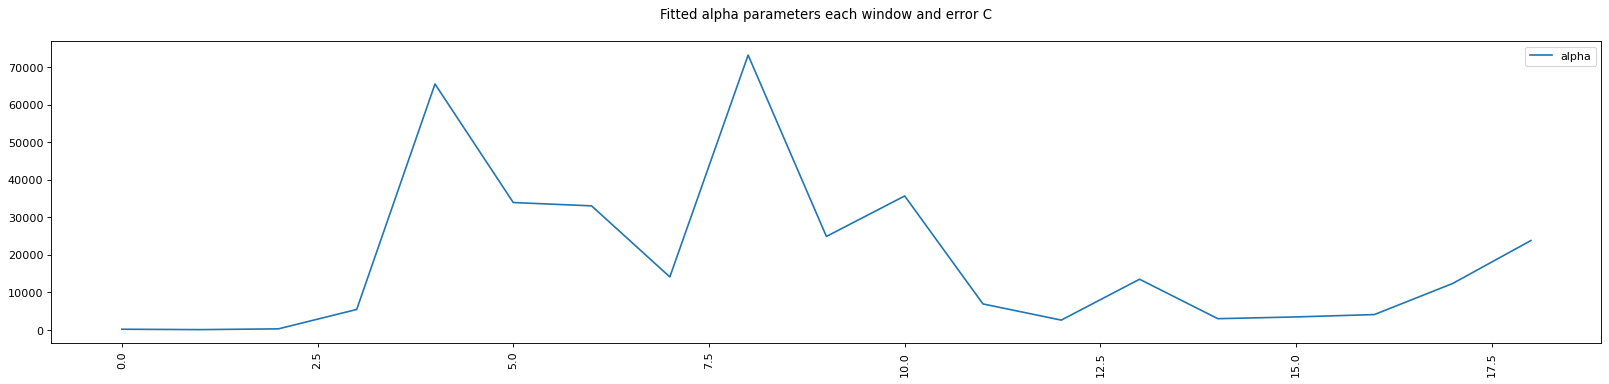

In [43]:
## Plotting fitted parameters alpha for each window
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted alpha parameters each window and error C\n", fontdict = {'fontsize' : 12})

plt.plot(alphas_C, label="alpha")

plt.xticks(rotation='vertical')
plt.legend()
plt.show()

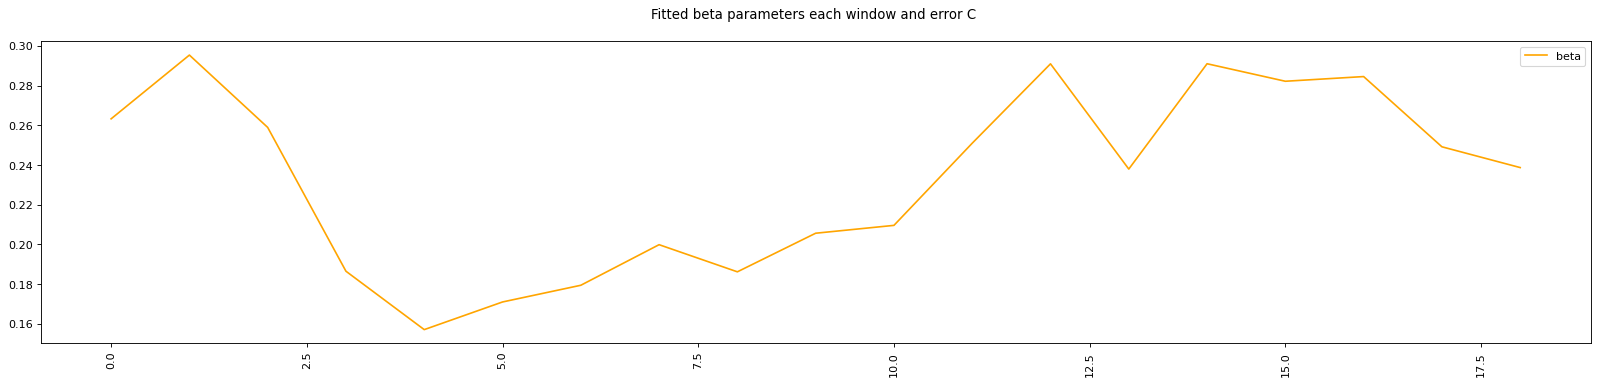

In [51]:
## Plotting fitted parameters beta for each window
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted beta parameters each window and error C \n", fontdict = {'fontsize' : 12})

plt.plot(betas_C, label="beta", color="orange")

plt.xticks(rotation='vertical')
plt.legend()
plt.show()

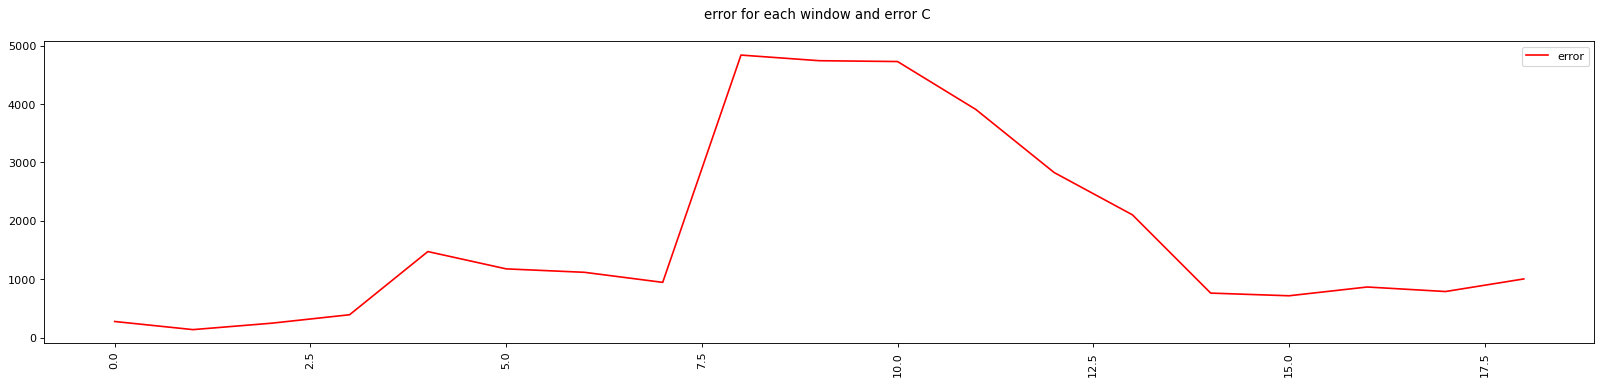

In [50]:
## Plotting error for each window
plt.figure(figsize=(25, 5), dpi=80)
plt.title("error for each window and error C \n", fontdict = {'fontsize' : 12})

plt.plot(errs_C, label="error", color="red")

plt.xticks(rotation='vertical')
plt.legend()
plt.show()